### Synthetic Data

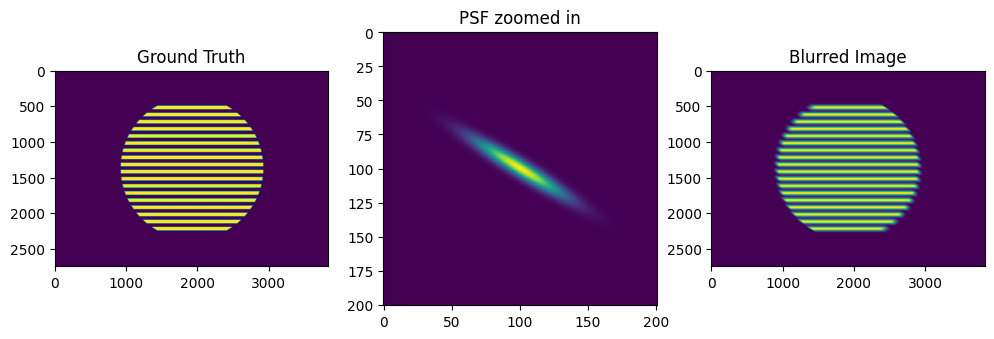

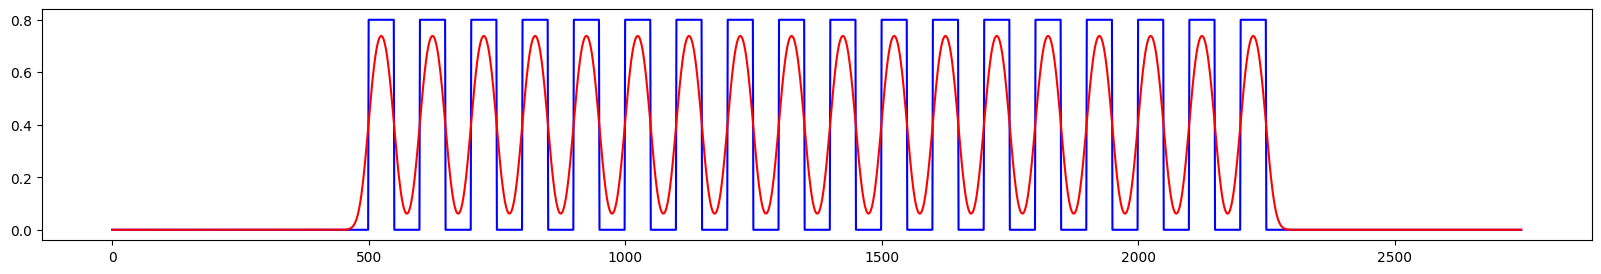

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyproximal

from scipy.signal import fftconvolve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import Gradient
from pylops.signalprocessing import Convolve2D
from pylops.utils import dottest

%reload_ext autoreload
%autoreload 2 

plt.figure(figsize=(12, 6))
# Create Synthetic Horizontal Stripes Pattern Image
im_s = np.zeros((2748, 3840))
stripe_width, stripe_gap, stripe_start, stripe_end = 50, 50, 500, 500
for y in range(0, im_s.shape[0]-(stripe_start+stripe_end), stripe_width + stripe_gap):
    im_s[stripe_start+y : stripe_start+y + 50, :] = .8

xx, yy = np.mgrid[0:im_s.shape[0], 0:im_s.shape[1]]
im_ctr = (np.array(im_s.shape)/2).astype(int)
r = np.sqrt((xx - im_ctr[0])**2 + (yy - im_ctr[1])**2)
mask = np.zeros_like(im_s)
mask[r < 1000] = 1
im_s *= mask

# Create Gaussian Kernel & Convolve
from scipy.stats import multivariate_normal
x, y = np.mgrid[0:im_s.shape[0], 0:im_s.shape[1]]
pos = np.dstack((x, y))
rv = multivariate_normal.pdf(pos, im_ctr, [[200, 0], [300, 500]])
psf2 = rv/np.sum(rv)
psf2_crop = psf2[im_ctr[0]-100:im_ctr[0]+101, im_ctr[1]-100:im_ctr[1]+101]

# Convolve and Create Blurred Image
Cop = Convolve2D(im_s.shape, psf2_crop, offset=(psf2_crop.shape[0]//2, psf2_crop.shape[1]//2))
im_sb1 = Cop @ im_s

plt.subplot(131); plt.imshow(im_s); plt.title('Ground Truth');
plt.subplot(132); plt.imshow(psf2_crop); plt.title('PSF zoomed in');
plt.subplot(133); plt.imshow(im_sb1); plt.title('Blurred Image');

plt.figure(figsize=(20, 3))
plt.plot(im_s[:, 2000],'b')
plt.plot(im_sb1[:, 2000], 'r')

### Proximal Gradient

Forward evaluations: 5, L: 0.9385918950976766
Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.TV.TV'>
tau = 1.0531914893617023	beta=5.000000e-01
epsg = 1.0	niter = 10	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   2.80413e-17   2.684e+03   5.184e+01   2.736e+03   1.053e+00
     2   1.47935e-17   8.356e+02   5.679e+01   8.924e+02   1.053e+00
     3   2.49254e-17   2.061e+02   6.016e+01   2.663e+02   1.053e+00
     4   1.69047e-17   6.661e+01   6.202e+01   1.286e+02   1.053e+00
     5   1.69895e-17   4.568e+01   6.279e+01   1.085e+02   1.053e+00
     6   4.95366e-18   3.793e+01   6.295e+01   1.009e+02   1.053e+00
     7  -1.90506e-18   3.132e+01   6.285e+01   9.417e+01   1.053e+00
     8  -1.21610e-17   2.713e+01   6.271e+01   8.983e+01   1.053e+00
     9  -1.65677e-17   2.470e+01   6.259e+01   

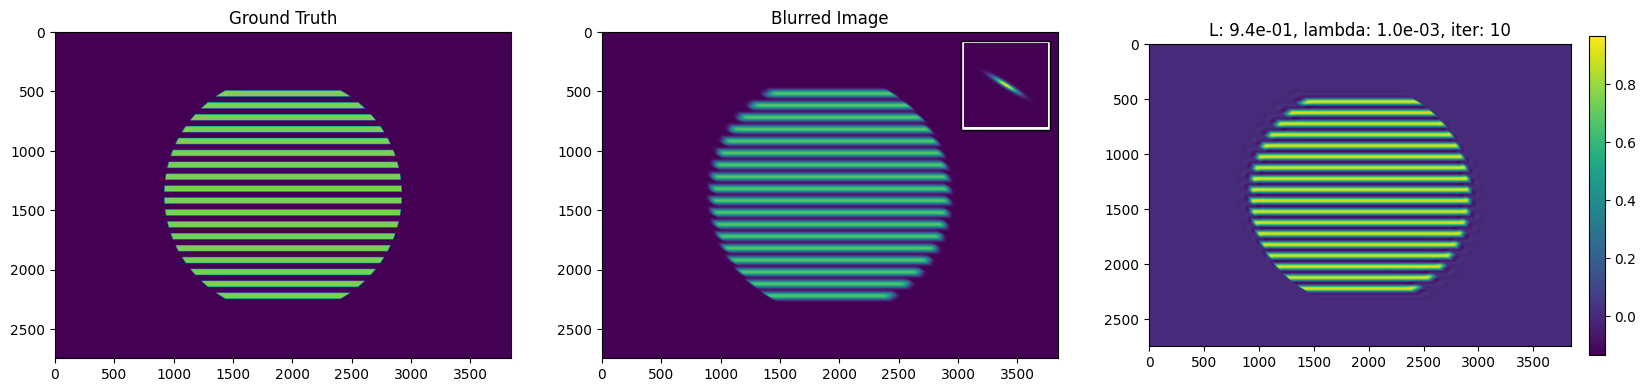

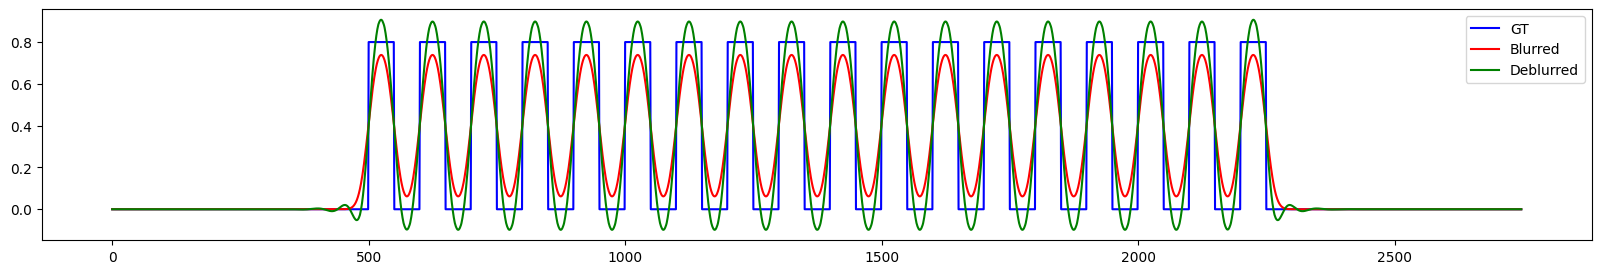

In [2]:
# ProxGrad (Blockiness-promoting inversion with isotropic TV)

# Learning rate
COp2 = Cop.H * Cop
L = np.real(COp2.eigs(neigs=1, ncv=5, niter=4, tol=1e-1))[0]
print(f"Forward evaluations: {COp2.matvec_count}, L: {L}")
tau = 1e0* 0.99/L

# Cost
l2 = pyproximal.L2(Op=Cop, b=im_sb1.ravel(), x0=im_sb1.ravel(), niter=10, warm=True)

# Prior
lbd = 1e-3
tv = pyproximal.TV(dims=im_s.shape, sigma=lbd)

# Solver
maxiter=10
im_debl = pyproximal.optimization.primal.ProximalGradient(l2, tv, x0=im_sb1.ravel(), 
                                                          tau=tau, niter=maxiter, 
                                                          acceleration='fista', show=True)
im_debl = im_debl.reshape(im_s.shape)

# Visualize
plt.figure(figsize=(20, 10))
plt.subplot(131); plt.imshow(im_s, vmin=0, vmax=1); plt.title('Ground Truth');
ax= plt.subplot(132); plt.imshow(im_sb1, vmin=0, vmax=1); plt.title('Blurred Image');
plt.subplot(133); plt.imshow(im_debl);plt.title(f'L: {L:.1e}, lambda: {lbd:.1e}, iter: {maxiter}'); plt.colorbar(fraction=0.035, pad=0.04)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
im = OffsetImage(psf2_crop, zoom=.3)
artists = []
ab = AnnotationBbox(im, (3400, 450), xycoords='data', frameon=True, pad=.2)
artists.append(ax.add_artist(ab))

plt.figure(figsize=(20, 3))
plt.plot(im_s[:, 2000],'b')
plt.plot(im_sb1[:, 2000], 'r')
plt.plot(im_debl[:, 2000], 'g');
plt.legend(['GT', 'Blurred', 'Deblurred'])

### Generalized Proximal Gradient

Forward evaluations: 5, L: 0.9383816950647442
Generalized Proximal Gradient
---------------------------------------------------------
Proximal operators (f): [<class 'pyproximal.proximal.L2.L2'>]
Proximal operators (g): [<class 'pyproximal.proximal.TV.TV'>]
tau = 1.053191e+00
epsg = 1	niter = 10

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   2.80413e-17   2.684e+03   5.184e+01   2.736e+03   1.053e+00
     2   1.58648e-17   8.356e+02   5.679e+01   8.924e+02   1.053e+00
     3   2.15554e-17   1.496e+02   6.084e+01   2.105e+02   1.053e+00
     4   2.56797e-17   7.767e+01   6.336e+01   1.410e+02   1.053e+00
     5   2.82839e-17   1.091e+02   6.433e+01   1.734e+02   1.053e+00
     6   1.09025e-17   8.038e+01   6.412e+01   1.445e+02   1.053e+00
     7  -1.97657e-18   4.006e+01   6.333e+01   1.034e+02   1.053e+00
     8  -2.02162e-17   3.236e+01   6.252e+01   9.489e+01   1.053e+00
     9  -2.40468e-17   3.949e+01   6.206e+01   1.015e+02   1.053e+00
    10  -4.143

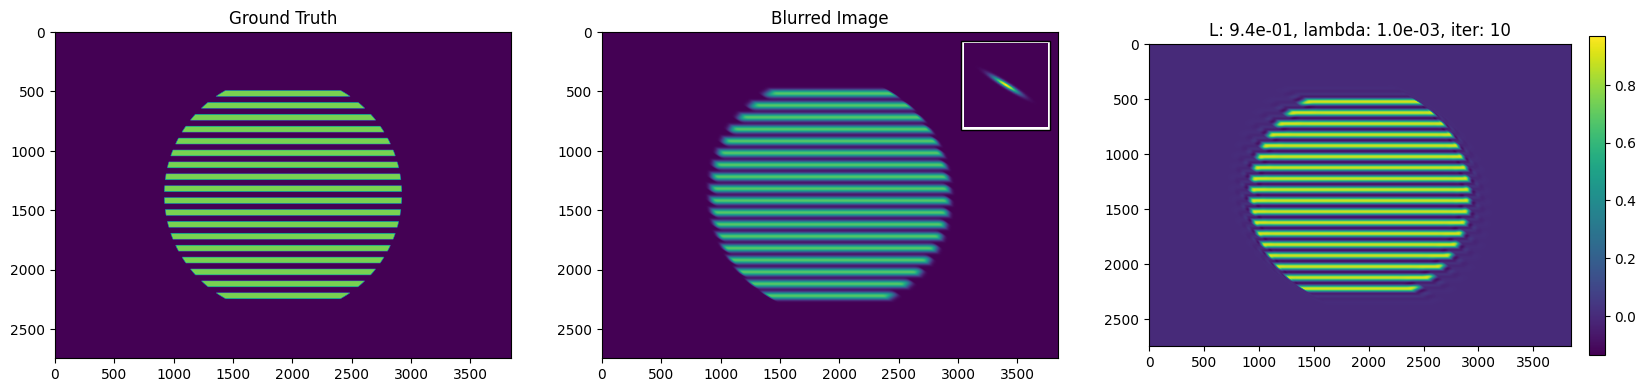

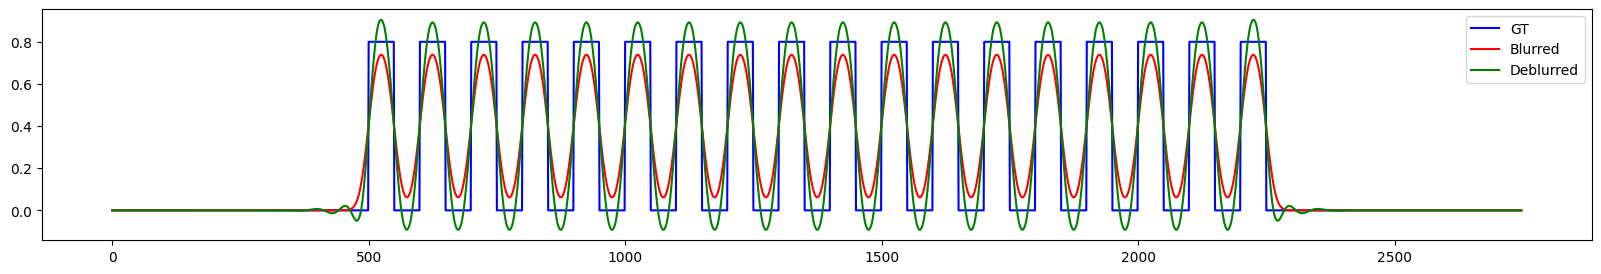

In [3]:
# Generalized ProxGrad (Blockiness-promoting inversion with isotropic TV)

# Learning rate
COp2 = Cop.H * Cop
L = np.real(COp2.eigs(neigs=1, ncv=5, niter=4, tol=1e-1))[0]
print(f"Forward evaluations: {COp2.matvec_count}, L: {L}")
tau = 1e0*0.99/L

# Cost
l2 = pyproximal.L2(Op=Cop, b=im_sb1.ravel(), x0=im_sb1.ravel(), niter=10, warm=True)

# Prior
lbd = 1e-3
tv = pyproximal.TV(dims=im_s.shape, sigma=lbd)

# Solver
maxiter=10
im_debl = pyproximal.optimization.primal.GeneralizedProximalGradient([l2], [tv], x0=im_sb1.ravel(), 
                                                                     tau=tau, niter=10, epsg=1,
                                                                     acceleration='fista', show=True)
im_debl = im_debl.reshape(im_s.shape)

# Visualize
plt.figure(figsize=(20, 10))
plt.subplot(131); plt.imshow(im_s, vmin=0, vmax=1); plt.title('Ground Truth');
ax= plt.subplot(132); plt.imshow(im_sb1, vmin=0, vmax=1); plt.title('Blurred Image');
plt.subplot(133); plt.imshow(im_debl);plt.title(f'L: {L:.1e}, lambda: {lbd:.1e}, iter: {maxiter}'); plt.colorbar(fraction=0.035, pad=0.04)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
im = OffsetImage(psf2_crop, zoom=.3)
artists = []
ab = AnnotationBbox(im, (3400, 450), xycoords='data', frameon=True, pad=.2)
artists.append(ax.add_artist(ab))

plt.figure(figsize=(20, 3))
plt.plot(im_s[:, 2000],'b')
plt.plot(im_sb1[:, 2000], 'r')
plt.plot(im_debl[:, 2000], 'g');
plt.legend(['GT', 'Blurred', 'Deblurred'])